# **Text Preprocessing Using NLP**



**The purpose of this project is to apply tokenization, stemming, lemmatization, and stop word removal techniques on the Twitter US Airline Sentiment Dataset. The following notebook will provide hands-on experience in text preprocessing using NLP techniques.**

# DATA EXPLORATION

In [1]:
import pandas as pd
import zipfile

zip_file_path = '/content/Tweets.csv.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

csv_file_path = '/content/Tweets.csv'
df = pd.read_csv(csv_file_path)

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


There are a lot of columns here not conducive to a text preprocessing (tokenization, stemming, lemmatization, and stop word removal) project.

# Drop:

**tweet_id**: Just an identifier, not necessary for text analysis.

**airline_sentiment_confidence:** Unhelpful for basic text preprocessing.

**negativereason:** Not necessary unless planning to analyze specific
 reasons behind negative sentiment. (which I'm not doing here)

**negativereason_confidence**: Not relevant unless you plan on studying negative reasons in more detail.

**airline_sentiment_gold, negativereason_gold:** Used for advanced modeling purposes, can be dropped.

**name, retweet_count, tweet_coord, tweet_created, tweet_location, user_timezone:** Metadata not relevant to text preprocessing.


# Keep:

**text:** This is the main column containing the tweets, which is the focus of this text preprocessing project.

**airline_sentiment:** This column could be useful for model sentiment after processing the text. Keeping it as an option for later is helpful.

In [3]:
# Drop unnecessary columns
columns_to_drop = [
    'tweet_id', 'airline_sentiment_confidence', 'negativereason',
    'negativereason_confidence', 'airline_sentiment_gold', 'name',
    'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created',
    'tweet_location', 'user_timezone' , 'airline'
]

df_cleaned = df.drop(columns=columns_to_drop)

df_cleaned.head()


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


For data exploration in the context of text analysis its important to gain a basic understanding of the textual data and sentiment distribution.

# 1. Sentiment Distribution:

Understanding the distribution of sentiments (positive, neutral, negative) can can be very informative for the overall dataset's balance or imbalance. The investigation of this balance is a crucial first step to any future machine learning models that may be leveraged.

In [4]:
# code to check sentiment distribution
sentiment_distribution = df_cleaned['airline_sentiment'].value_counts()

sentiment_distribution

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


Major Imbalance: The dataset is heavily skewed towards negative sentiment, which is nearly four times the number of positive tweets.

**Strategies To Consider For Later:**

**Balancing the Dataset**: If a model is going to be built off this data balancing the dataset is crucial. (Some exeptions I wont get into now) Techniques like oversampling the positive and neutral tweets or undersampling for undersampling the negative ones are typically applied.

**Weighted Metrics:** If classification models are developed, using weighted metrics can account for the imbalance.

# 2. Basic Descriptive Statistics:

Extracting the number of characters, words, and unique words in the text column will help to understand the overall length and diversity of the data.

In [5]:
# Add a column for text length (this means number of characters)
df_cleaned['text_length'] = df_cleaned['text'].apply(len)

# Add a column for word count
df_cleaned['word_count'] = df_cleaned['text'].apply(lambda x: len(x.split()))

# Display desc stats
df_cleaned[['text_length', 'word_count']].describe()


,text_length,word_count
count,14640.000000,14640.000000
mean,103.822063,17.653415
std,36.277339,6.882259
min,12.000000,2.000000
25%,77.000000,12.000000
50%,114.000000,19.000000
75%,136.000000,23.000000
max,186.000000,36.000000


**Text Complexity:** The tweets aren't too long or complex, which makes the upcoming preprocessing (tokenization, stemming, etc.) relatively straightforward.

**Potential Noise:** Tweets with only 2-3 words might introduce noise and may not bring that much value. These are good candidates for exclusion.

**Consistency:** There's a reasonable spread of tweet lengths, which is to be expected in a social media datasets where users write short and long responses.

# 3. Most Frequent Words:

Identifying the most common words before preprocessing can give insights into the dominant terms and noise in the dataset. These include common stop words (e.g., "the," "is") that I will remove later.

In [6]:
from collections import Counter
import re

# Combining all tweets into a single string makes it easier to work with
all_text = ' '.join(df_cleaned['text'])

# Tokenize the text by splitting on whitespace and removing punctuation
tokens = re.findall(r'\b\w+\b', all_text.lower())

# Extract the frequency of each word
word_freq = Counter(tokens)

# Display the 10 most common words
word_freq.most_common(10)


[('to', 8652),
 ('i', 6703),
 ('the', 6061),
 ('a', 4514),
 ('you', 4401),
 ('united', 4164),
 ('for', 3999),
 ('flight', 3939),
 ('on', 3815),
 ('and', 3733)]

The most frequent words include "to," "i," "the," "a," "for," "on," and "and."
These stop words don’t carry much meaningful information for understanding the tweet content, so removing them during preprocessing (which I will do soon) is very important for reducing noise.

"**united**" and "**flight**" are the only domain-specific words in the top 10. "**United**" refers to the airline United Airlines, which seems to be a common subject of tweets. This could suggest user complaints or discussions around United Airlines flights is found frequently.


# 4. Null or Missing Values

In [7]:
missing_values = df_cleaned.isnull().sum()

missing_values


,0
airline_sentiment,0
text,0
text_length,0
word_count,0


# 5. Example of Random Tweets by Sentiment

It can be helpful to look at random tweets for each sentiment category to understand the nature of the text data.

In [8]:
# Display 2 random tweets from each sentiment
for sentiment in df_cleaned['airline_sentiment'].unique():
    print(f"\nExamples of '{sentiment}' tweets:")
    print(df_cleaned[df_cleaned['airline_sentiment'] == sentiment]['text'].sample(2).values)



Examples of 'neutral' tweets:
['@united speaking of my flight, skateboards are allowed as carry on bagage right? No extra payment needed?'
 '@united what is your plan to reduce delays?']

Examples of 'positive' tweets:
['@united since when did you get so good again!  4 transcontinental flights in 72h.  What a pleasure/relief you were.'
 '@united thank you. Been trying for two days to set this up.']

Examples of 'negative' tweets:
['@united is really getting horrible. So much for tucking in my kids tonight. Delta transfers miles/status, right? http://t.co/H6HN33JJJE'
 '@USAirways PLEASE improve your phone system! Going through multiple prompts &amp; menus just to be told to call back Late Flightr = MAJOR FAIL']


**Neutral tweets** tend to be straightforward questions or observations without strong emotion.

**Positive tweets** often contain expressions of relief or appreciation, indicating satisfaction with the airline’s service.

**Negative tweets** contain complaints, frustration, and sometimes sarcasm or anger about delays, poor service, or inconveniences.

# TEXT PREPROCESSING

# Steps

**Lowercasing:** Converts all text to lowercase to make sure that words like
“Flight” and “flight” are treated the same.

**Remove punctuation:** This removes all punctuation characters (e.g., commas, periods, question marks) to keep the text clean.

**Tokenization:** Splits the text into individual words or tokens.

**Stop word removal:** Removes the common stop words providing little to no value.

**Lemmatization:** Converts words to their base or dictionary form.

**Exclude tweets with 2-3 words:** Filter out tweets that have 3 words or fewer.


In [9]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK tools
stop_words = set(stopwords.words('english'))  # Stop language in English
stop_words.update(['to', 'i', 'the', 'a', 'for', 'on', 'and'])
stemmer = PorterStemmer()  # Initializing stemmer (we won't use this but here is the code for the stemmer)
lemmatizer = WordNetLemmatizer()  # Initializing lemmatizer

# Function/code to preprocess each tweet
def preprocess_text(text):
    # 1. Lowercase the text
    text = text.lower()

    # 2. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Tokenize the text
    tokens = word_tokenize(text)

    # 4. Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Lemmatization (Or Stemming)
    # tokens = [stemmer.stem(word) for word in tokens]  # this line is for stemming, we are not using it but I wanted to show what It looks like.

    #Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Drop out tweets with less than 3 words
df_cleaned = df_cleaned[df_cleaned['word_count'] > 3]

# Apply this preprocessing to the 'text' column
df_cleaned['processed_text'] = df_cleaned['text'].apply(preprocess_text)

# Make sure it worked by displaying head
df_cleaned[['text', 'processed_text']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,processed_text
0,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,virginamerica plus youve added commercial expe...
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica didnt today must mean need take ...
3,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


# Visualization:

Creating visualizations is a great way to better understand the impact of preprocessing:

**Word Frequency Bar Plot**: Displays the top 10 most frequent words after preprocessing.

**Word Cloud:** A fun visual representation of word frequency, where larger words appear more frequently.

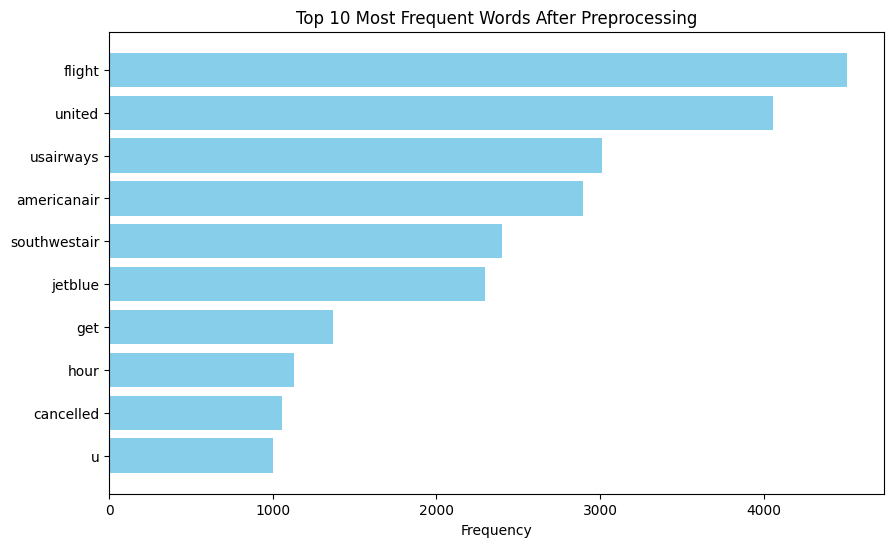

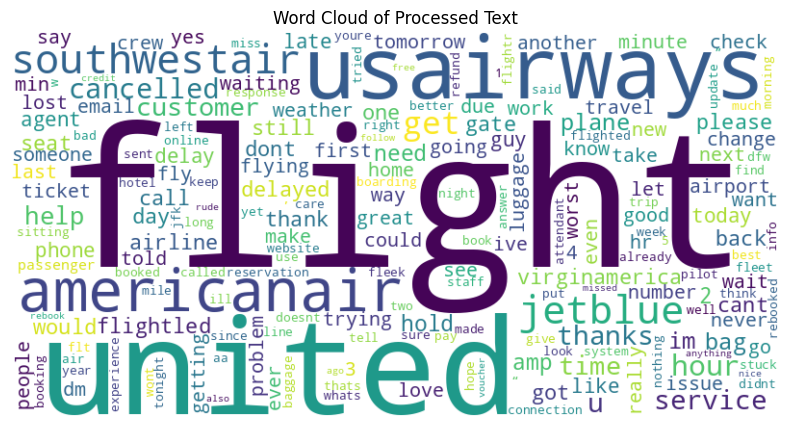

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Create a list of all words in the processed text
all_words = ' '.join(df_cleaned['processed_text']).split()

# Count the frequency of each word
word_freq = Counter(all_words)

# Now visualize the top 10 most frequent words
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)

# Bar Plot for top 10 most frequent words
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Words After Preprocessing')
plt.gca().invert_yaxis()
plt.show()

# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Code to show the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Text')
plt.show()


# Conclusion and Takeaways:

Text preprocessing is extremely critical in NLP as it ensures that raw text is converted into a clean and well-structured format, making the subsequent analysis and modeling tasks efficient and effective. This process involves the steps we saw above, such as tokenization, stop word removal, punctuation elimination, and normalization (stemming or lemmatization). Through these steps, noise is reduced, and valuable information is extracted. This allows machine learning models to focus on relevant info and improve the accuracy of text analysis.

During the preprocessing process one challenge was dealing with data imbalance, particularly in short texts like tweets, where outliers (in this case, tweets with only 2-3 words) needed to be excluded to ensure balance and avoid skew. Also, the presence of frequent, non-informative words like stop words and airline names was removed. Another challenge was handling informal language, contractions, and abbreviations often found in social media texts, which required tokenization and lemmatization.

Text preprocessing techniques are pervasive in NLP, they show up in sentiment analysis, topic modeling, machine translation, and chatbot development mongst many others tasks. By improving the quality of input text, these techniques help models focus on patterns inherent to the data, making predictions more accurate and (hopefully) reducing overfitting. In niche domains like customer feedback analysis, social media monitoring, and automated text generation, preprocessing ensures that downstream tasks are not only more efficient but also more interpretable and actionable.
